# Benchmark

In [2]:
# Settings
root_dir = '/home/dennis/VILLASnode/tests/benchmarks'
benchmark_dir = 'benchmarks_20180731_16-22-41'

## Load all files
Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua.

In [3]:
import numpy as np
import os

# Initialize arrays
result_files = []
result_paths = []
result_array = []

# Save complete path of files in an array
for subdir, dirs, files in os.walk(root_dir+'/'+benchmark_dir):
    for file in files:
        result_paths.append(os.path.join(subdir, file))
        
    result_files = files

# Loop through array with files and save the comma separated data into a new array
for file in result_paths:
    print("Loaded {}".format(file))
    
    # Load file 
    result_array.append(np.genfromtxt(file, delimiter=','))


Loaded /home/dennis/VILLASnode/tests/benchmarks/benchmarks_20180731_16-22-41/0_TCP-3-100000-3000000.csv


## Save characteristics of tests
All important settings are contained in the name of the file. We will save them in a separate array. The structure of the name is as follows:

```bash
root_dir/benchmarks_${DATE}/${ID}_${MODE}-${VALUES IN SMP}-${RATE}-${SENT SMPS}
```

Thus, we will structure it in the settings_array as follows:

* `settings_array[*][0] = ID`
* `settings_array[*][1] = MODE`
* `settings_array[*][2] = VALUES IN SAMPLE`
* `settings_array[*][3] = RATE`
* `settings_array[*][4] = TOTAL NUMBER OF SAMPLES`

In [4]:
import re

# Array with settings
settings_array = []

for file in result_files:
    settings = []
    
    matchObj = re.match( r'(\d*)_(\w*)-(\d*)-(\d*)-(\d*).csv', file, re.M|re.I)

    # Fill values to array
    for i in range(0,5):
        settings.append(matchObj.group(i+1))
    
    # Append array to big array
    settings_array.append(settings)

## Process data

### Number of samples
* First number which appears in `result_array[*][3]` will be the first sample in the benchmark. Ignore all missing samples before that entry.
* After that, check how many samples are missing.
* Then, calculate the percentage of missing samples.

In [5]:
# Sequence number of first sample that occurs are receive side
start_sequence = []
# Real total number of sent messages, after subtraction of first sequence
real_total_arr = []
# Number of missing samples after first sample
number_miss_arr = []
# Percentage of missed samples
perc_miss_arr = []

# Generate real total and number of missing samples.
# Print percentage of missed samples
for (i, csv_vec) in enumerate(result_array):
    start_sequence.append(csv_vec[0][3])
    
    # Real total number = total number - start_seqquence
    # Number missing = real total number - length of data arary
    real_total = int(settings_array[i][4]) - int(start_sequence[i])
    number_miss = real_total - len(csv_vec)
    perc_miss = round(number_miss / real_total * 100, 3)
    
    print("Test {} missed {} ({}%) of {} ({} before correction) samples"
          .format(i, number_miss, perc_miss, real_total, settings_array[i][4]))
    
    real_total_arr.append(real_total)
    number_miss_arr.append(number_miss)
    perc_miss_arr.append(perc_miss)

Test 0 missed 68 (0.002%) of 2995948 (3000000 before correction) samples


## Plot data
We want to plot the offset

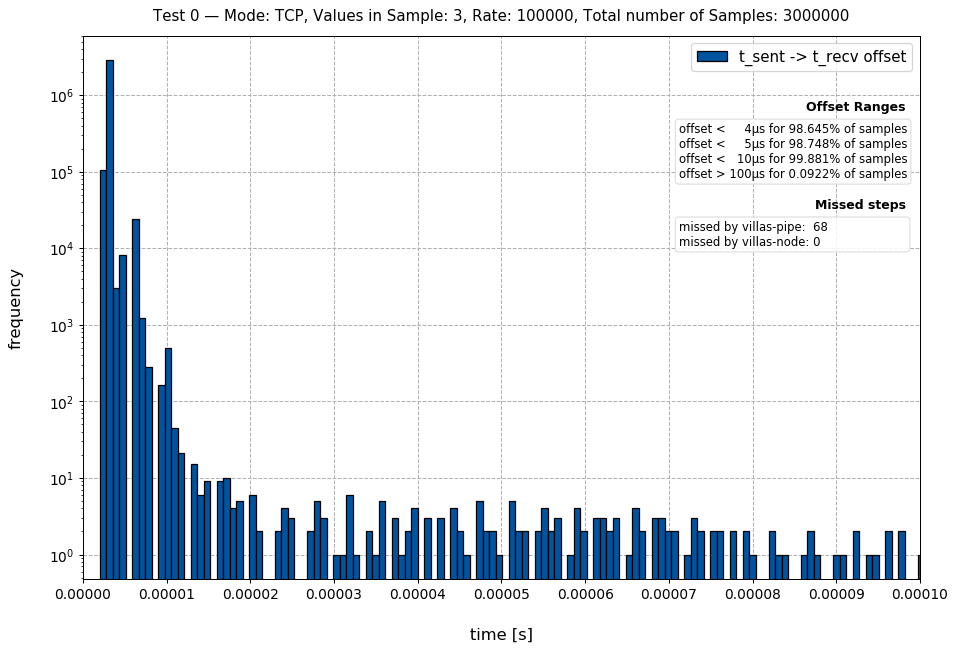

In [84]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import os

# Start creating plots
for i, val in enumerate(result_array):
    # Create figure
    fig = plt.figure(num=None, figsize=(12, 8), dpi=90, facecolor='w', edgecolor='k')

    # Add plot and set title
    ax = fig.add_subplot(111)
    
    # Set subtitle 
    title = "Test {} — Mode: {}, Values in Sample: {}, Rate: {}, Total number of Samples: {}".format(settings_array[i][0],
                                                                                                     settings_array[i][1], 
                                                                                                     settings_array[i][2], 
                                                                                                     settings_array[i][3], 
                                                                                                     settings_array[i][4])
    ax.set_title(title, fontsize=12, pad=12, loc='center')
    
    # Set grid
    ax.set_axisbelow(True)
    ax.grid(True, linestyle='--')

    bins = 6250
    x_limit=0.0001
    
    # Data in plot
    # http://www.color-hex.com/color-palette/33602
    val_t = val.transpose()
    
    ax.hist(val_t[2], label='t_sent -> t_recv offset', edgecolor='black', bins=bins, color='#00549f')

    # Set axis and calculate values above limit
    plt.xlim([0,x_limit])
       

    plt.xticks(np.arange(0, x_limit + 0.000001, 0.00001), fontsize=11)
    plt.yticks(fontsize=11)

    # Labels
    ax.set_xlabel('time [s]', fontsize=13, labelpad=20)
    ax.set_ylabel('frequency', fontsize=13, labelpad=20)
    ax.set_yscale('log')

    # Create text for offset
    off_smaller_4us  = round((np.size(val_t[2][val_t[2] < 0.000004]) / np.size(val_t[2])) * 100, 3)
    off_smaller_5us  = round((np.size(val_t[2][val_t[2] < 0.000005]) / np.size(val_t[2])) * 100, 3)
    off_smaller_10us = round((np.size(val_t[2][val_t[2] < 0.00001]) / np.size(val_t[2])) * 100, 3)
    off_bigger_100us = round((np.size(val_t[2][val_t[2] > x_limit]) / np.size(val_t[2])) * 100, 4)
    
    offset_text  = 'offset <     {} for {}% of samples\n'.format('4µs', off_smaller_4us)
    offset_text += 'offset <     {} for {}% of samples\n'.format('5µs', off_smaller_5us)
    offset_text += 'offset <   {} for {}% of samples\n'.format('10µs', off_smaller_10us)
    offset_text += 'offset > {} for {}% of samples'.format('100µs', off_bigger_100us)
    
    # Create text for missed steps
    #ToDo: Add percentage
    missed_text  = 'missed by villas-pipe:  {0: <23}\n'.format(number_miss_arr[i])
    missed_text += 'missed by villas-node: {0: <23}'.format(number_miss_arr[i] - number_miss_arr[i])
           
    # bbox accepts FancyBboxPatch prop dict
    font_header = FontProperties()
    font_header.set_weight('bold')
    font_header.set_size(10)
    
    # Offset boxes
    ax.text(0.983, 0.88, "Offset Ranges",
            verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes,
            color='black', fontproperties = font_header)
    ax.text(0.712, 0.84, offset_text,
            verticalalignment='top', horizontalalignment='left',
            transform=ax.transAxes,
            color='black', fontsize=9.25,
            bbox={'facecolor':'white', 'alpha':0.85, 'pad':0.3, 'boxstyle':'round',
                  'edgecolor':'#dbdbdb'})
    
    # Missed steps
    ax.text(0.983, 0.70, "Missed steps",
            verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes,
            color='black', fontproperties = font_header)
    ax.text(0.712, 0.66, missed_text,
            verticalalignment='top', horizontalalignment='left',
            transform=ax.transAxes,
            color='black', fontsize=9.25,
            bbox={'facecolor':'white', 'alpha':0.85, 'pad':0.3, 'boxstyle':'round',
                  'edgecolor':'#dbdbdb'})

    #Create legend
    ax.legend(loc=1, fontsize=12)
    

    #Show plot
    plt.show()
    
    #Save plot
    fig.savefig('./plots/test{}.png'.format(i))